# ADA project - Milestone 2

Team : ThePirateOfTheStreet


## Part 1: Importing and handling dataset to obtain relational table for movie genres

#### 1.1) Libraries and datasets

In [3]:
# Imports of necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# import the CMU movie datasets
movie_column_names = ['Wikipedia_movie_ID',
                'Freebase_movie_ID',
                'movie_name',
                'movie_release_date',
                'movie_box_office_revenu',
                'movie_runtime',
                'movie_languages',
                'movie_countries',
                'movie_genres']

df_movies = pd.read_csv("MovieSummaries\movie.metadata.tsv", delimiter='\t', names = movie_column_names)
df_summaries = pd.read_csv('MovieSummaries/plot_summaries.txt', delimiter='\t', names=['movie_ID', 'movie_summary'])

In [3]:
# Convert the genres into dictionnaries
genres_list = df_movies['movie_genres'].apply(lambda x: eval(x) if pd.notna(x) else {})

# Initialize an empty list to store the new relations <movie, genre>
new_rows = []

# Iterate over each row and process the genre dictionaries into new rows related to movie_id
for i, genres_dict in enumerate(genres_list):
    movie_id = df_movies.loc[i, 'Wikipedia_movie_ID']

    for genre_id, genre_name in genres_dict.items():
        new_rows.append({'Wikipedia_movie_ID': movie_id, 'Freebase_genre_ID': genre_id, 'movie_genre': genre_name})

# Create a new DataFrame from the list of rows and save it as csv
df_genres = pd.DataFrame(new_rows)
df_genres.to_csv('cleaned_genres.csv', index=False)
print(df_genres.head())

   Wikipedia_movie_ID Freebase_genre_ID      movie_genre
0              975900         /m/01jfsb         Thriller
1              975900          /m/06n90  Science Fiction
2              975900          /m/03npn           Horror
3              975900         /m/03k9fj        Adventure
4              975900          /m/0fdjb     Supernatural


#### 1.3) All unique mentioned genres and their relative appearance

In [4]:
unique_genres = df_genres[['Freebase_genre_ID','movie_genre']].groupby('movie_genre', as_index=False).aggregate([pd.Series.mode, 'count']).copy()
unique_genres.columns = ['Freebase_ID', 'movie_count']
unique_genres = unique_genres.sort_values(by='movie_count', ascending=False)
display(unique_genres)

,Freebase_ID,movie_count
movie_genre,,
Drama,/m/07s9rl0,34007
Comedy,/m/01z4y,16349
Romance Film,/m/02l7c8,10234
Black-and-white,/m/01g6gs,9094
Action,/m/02kdv5l,8798
...,...,...
Comdedy,/m/0bbctgg,1
New Queer Cinema,/m/022wy7,1
Linguistics,/m/0hj3nb2,1


Text(0.5, 0, 'Count of movies associated to the genre')

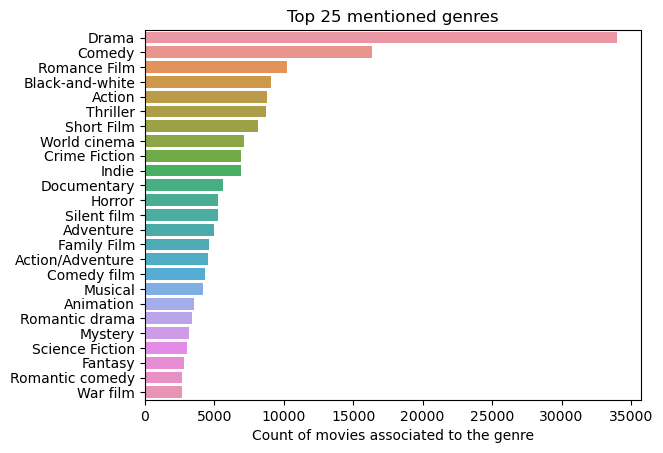

In [5]:
sns.barplot(data = unique_genres[['movie_count']].head(25).reset_index(),
            x = 'movie_count', y = 'movie_genre', orientation = 'horizontal')
plt.title("Top 25 mentioned genres")
plt.ylabel("")
plt.xlabel("Count of movies associated to the genre")

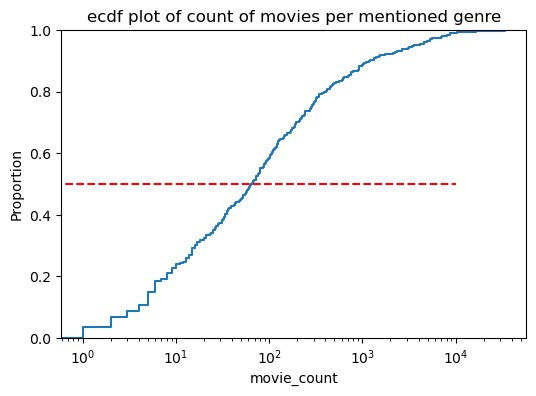

In [6]:
plt.figure(figsize=(6,4))
sns.ecdfplot(data = unique_genres, x = 'movie_count', log_scale=True)
plt.title("ecdf plot of count of movies per mentioned genre")
plt.hlines(y = 0.5, xmin = 0, xmax=1e4, linestyles='--', color = 'red')
# This would mean that 50% of the genres 

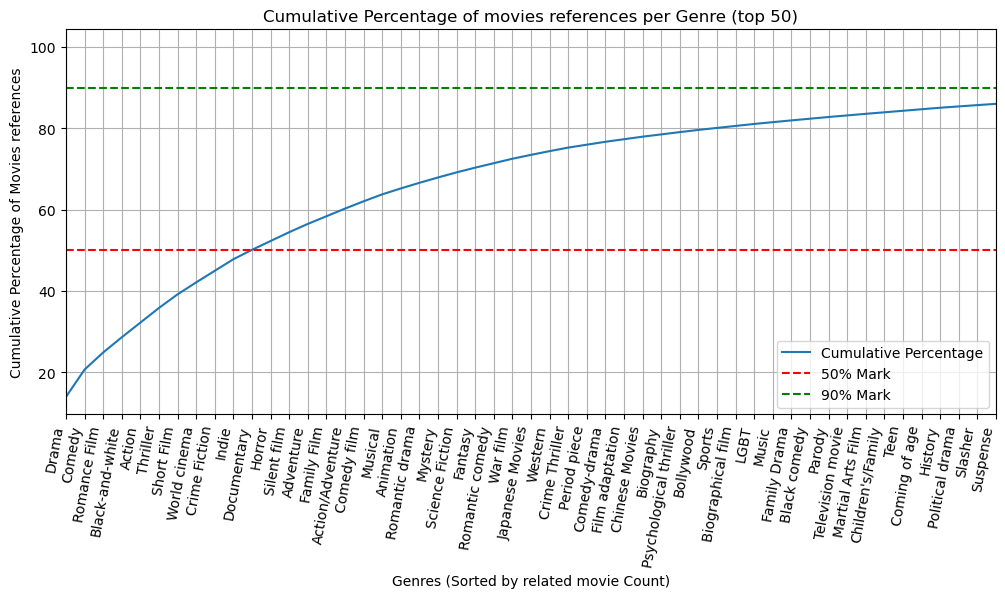

In [7]:
# Plot a cumulative percentage of movies by genre
plt.figure(figsize=(12, 5))
plt.plot((unique_genres['movie_count'].cumsum() / unique_genres['movie_count'].sum()) * 100,
         label='Cumulative Percentage')
plt.xticks(rotation=80, ha='right')
plt.xlim([0,50])

# Highlight the 50% and 90% mark
plt.axhline(y=50, color='r', linestyle='--', label='50% Mark')
plt.axhline(y=90, color='g', linestyle='--', label='90% Mark')

# Set labels and title
plt.xlabel('Genres (Sorted by related movie Count)')
plt.ylabel('Cumulative Percentage of Movies references')
plt.title('Cumulative Percentage of movies references per Genre (top 50)')
plt.legend()
plt.grid(True)
plt.show()

With this we can observe that if we take only the top 100 genres, almost 90% of the movie-genre relations are covered. 

# Part 2: Processing and statistics on two major genres related to fictional worlds : 'Science Fiction' and 'Fantasy'

In [8]:
df_fictional = df_genres[df_genres['movie_genre'].isin(['Science Fiction', 'Fantasy'])].copy()
print(f"The total number of movies referred to as fictional is {df_fictional['Wikipedia_movie_ID'].unique().size}, corresponding to {df_fictional['Wikipedia_movie_ID'].unique().size/df_movies['Wikipedia_movie_ID'].unique().size:.2%} of whole movies.")

The total number of movies referred to as fictional is 5366, corresponding to 6.56% of whole movies.


In [9]:
# populate the fictional genre dataset to add information on the movie as the release date
df_movies_fictional = pd.merge(df_fictional, df_movies[['Wikipedia_movie_ID', 'movie_name', 'movie_release_date']], on='Wikipedia_movie_ID', how='inner').copy()
df_movies_fictional['release_year'] =  pd.to_datetime(df_movies_fictional['movie_release_date'], format='mixed').dt.year
df_movies_fictional.head()

,Wikipedia_movie_ID,Freebase_genre_ID,movie_genre,movie_name,movie_release_date,release_year
0,975900,/m/06n90,Science Fiction,Ghosts of Mars,2001-08-24,2001.0
1,18998739,/m/01hmnh,Fantasy,The Sorcerer's Apprentice,2002,2002.0
2,11250635,/m/06n90,Science Fiction,The Mechanical Monsters,NaN,NaN
3,11250635,/m/01hmnh,Fantasy,The Mechanical Monsters,NaN,NaN
4,77856,/m/01hmnh,Fantasy,Mary Poppins,1964-08-27,1964.0


<Axes: xlabel='year', ylabel='count'>

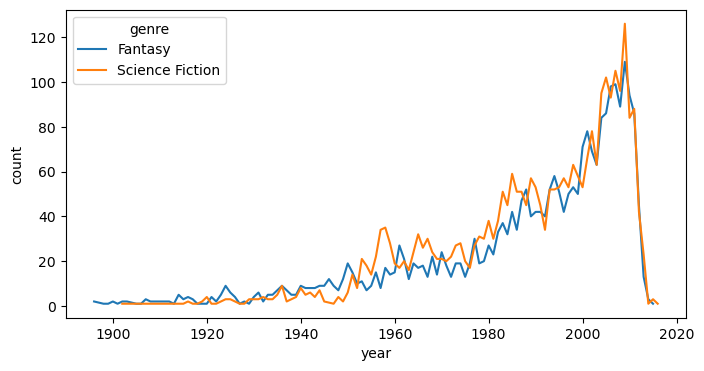

In [10]:
# We can now check if we observe already a difference between Fantasy and Science Fiction through years
plt.figure(figsize=(8,4))
genre_counts_per_year = df_movies_fictional.groupby(['release_year', 'movie_genre'])['Wikipedia_movie_ID'].agg('count').reset_index()
genre_counts_per_year.columns = ['year', 'genre', 'count']
sns.lineplot(data = genre_counts_per_year, x = 'year', y = 'count', hue = 'genre')

## Naive-Bayes ML for improved speculative fictional summaries classification ! 

We will for now, take all summaries of the genre "Science Fiction" and "Fantasy" vs the "documentary", "'Documentary', 'Biography', 'Culture & Society', 'Biographical film', 'Biopic [feature]' and 'History' as training of the classifier. This is for pipeline testing purpose and the biais and confounders of such a choice of training dataset should be discussed.

In [11]:
df_movies['Wikipedia_movie_ID'].unique().size, df_summaries['movie_ID'].unique().size

(81741, 42303)

In [12]:
fictional_wiki_movie_id = df_fictional['Wikipedia_movie_ID'].unique().copy()
non_fictional_wiki_movie_id = df_genres[df_genres['movie_genre'].isin(['Documentary', 'Biography', 'Culture & Society', 'Biographical film', 'Biopic [feature]', 'History'])]['Wikipedia_movie_ID'].unique().copy()
print(fictional_wiki_movie_id.size, non_fictional_wiki_movie_id.size)

5366 7778


In [63]:
fictional_summaries = df_summaries[df_summaries['movie_ID'].isin(fictional_wiki_movie_id)]['movie_summary']
non_fictional_summaries = df_summaries[df_summaries['movie_ID'].isin(non_fictional_wiki_movie_id)]['movie_summary']
print(len(fictional_summaries))
print(len(non_fictional_summaries))
fictional_summaries_undersampled = fictional_summaries.sample(len(non_fictional_summaries))
print(len(fictional_summaries_undersampled))
selected_summaries = pd.concat((fictional_summaries_undersampled, non_fictional_summaries)).copy()
labels = np.hstack((np.ones(fictional_summaries_undersampled.shape), np.zeros(non_fictional_summaries.shape)))
selected_summaries.shape

3941
2382
2382


(4764,)

In [64]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing with proportion 0.7 and 0.3.
x_train, x_test, y_train, y_test = train_test_split(selected_summaries, labels, test_size=0.3, random_state=42) 

print("Training set size:", len(x_train))
print("Test set size:", len(x_test))

Training set size: 3334
Test set size: 1430


The proportion are a bit unbalanced with around 60% fictional vs 40% non fictional

In [65]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [66]:
# Make the basic pipeline
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB()),
])
text_clf = text_clf.fit(x_train, y_train)
# test results
predicted = text_clf.predict(x_test)
np.mean(predicted == y_test)

0.8888111888111888

In [86]:
from sklearn.model_selection import GridSearchCV

# The different parameters
param_grid = {
    'vect__stop_words': ['english', None],
    'vect__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'clf__alpha': (1e-2, 1e-3),
    'clf__fit_prior': [False, True]
} 
# A higher value of alpha will result in a less complex model (less likely to overfit)

grid_search = GridSearchCV(text_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(x_train, y_train)

# Get the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print the best parameters and accuracy
for param, value in best_params.items():
    print(f"{param}: {value}")
print("Best accuracy:", grid_search.best_score_)

# Test the best model on the test data
predicted = best_model.predict(x_test)
accuracy = np.mean(predicted == y_test)
print("Accuracy on test data:", accuracy)

clf__alpha: 0.01
clf__fit_prior: True
tfidf__use_idf: False
vect__ngram_range: (1, 2)
vect__stop_words: english
Best accuracy: 0.9010175092633863
Accuracy on test data: 0.9083916083916084


In [92]:
with open("outlaws2023.txt", "r") as text_file:
    #read whole file to a string
    plot2test = text_file.read()

best_model.predict([plot2test])

array([1.])

In [93]:
t = x_test[y_test == 0].sample(1)
print(t.item())
best_model.predict(t)

The documentary  covers the birth and development of a professional style wrestling league from the mid 1980s that was produced by young teens aging from 12 to 16 years of age. The film covers the rise and fall of a unique wrestling experience for both the fans and kids that were involved. The film includes footage from the original NWF productions as well as current interviews with past NWF participants.


array([0.])

In [91]:
t = "The dangerous world of free diving, director Lauren McGann follows the early lives and careers of Italian free diver Alessia Zecchini, who's determined to break the world record, and Irish safety diver Stephen Keenan, who accompanies Zecchini partway down to help in case something goes wrong."
text_clf.predict([t])

array([0.])

In [81]:
# We can also try complexer vord vectorization

In [95]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gezas\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [24]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english", ignore_stopwords=True)

class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])
    
stemmed_count_vect = StemmedCountVectorizer(stop_words='english')

In [97]:
text_mnb_stemmed = Pipeline([('vect', stemmed_count_vect),
                             ('tfidf', TfidfTransformer()),
                             ('mnb', MultinomialNB(fit_prior=False))])

text_mnb_stemmed = text_mnb_stemmed.fit(x_train, y_train)
predicted_mnb_stemmed = text_mnb_stemmed.predict(x_test)
np.mean(predicted_mnb_stemmed == y_test)

0.8402741170268846

# Part 3: Feature extracting from the fictional movies

In [ ]:
import ntlk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize


# Data sample
sample_summaries = fictional_summaries.copy()

# General parameters to adapt
n_features = 1000
n_components = 10
n_top_words = 10

# Text preprocessing to remove Proper nouns (NPP)
def filter_names(text):
    """
    Filters out all Proper Nouns based on nltk token tags.

    Args:
        text (str): text to be filtered

    Returns:
        str: filtered text
    """
    tokens = word_tokenize(text)
    tagged_tokens = pos_tag(tokens)
    filtered_tokens = [token for token, pos in tagged_tokens if pos != 'NNP']
    return ' '.join(filtered_tokens)

# Preprocess the documents
preprocessed_sample_summaries = [filter_names(doc) for doc in sample_summaries]

# Vectorize the summaries
vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english")
dtm = vectorizer.fit_transform(preprocessed_sample_summaries)

lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=11,
)

lda.fit(dtm)

# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda, n_words=10):
    """
    ...

    Args:
        vectorizer (_type_, optional): _description_. Defaults to vectorizer.
        lda_model (_type_, optional): _description_. Defaults to lda.
        n_words (int, optional): _description_. Defaults to 10.

    Returns:
        _type_: _description_
    """
    keywords = np.array(vectorizer.get_feature_names_out())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

# Show the topics with their n_top words in a DataFrame form
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda, n_words=n_top_words)
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,tells,father,home,house,love,finds,day,children,family,mother
Topic 1,police,car,killed,town,kill,finds,escape,group,kills,killing
Topic 2,team,military,nuclear,government,mission,base,world,states,humans,bomb
Topic 3,human,robot,life,new,body,world,man,scientist,young,brain
Topic 4,time,machine,future,past,travel,present,events,years,day,year
Topic 5,planet,ship,space,alien,earth,aliens,moon,spaceship,energy,rocket
Topic 6,film,monster,movie,story,game,monsters,scene,characters,world,character
Topic 7,creature,crew,ship,creatures,island,water,sea,cave,boat,expedition
Topic 8,blood,vampire,evil,vampires,human,army,battle,kills,warriors,kill
Topic 9,fight,battle,escape,city,group,help,power,kill,return,killed


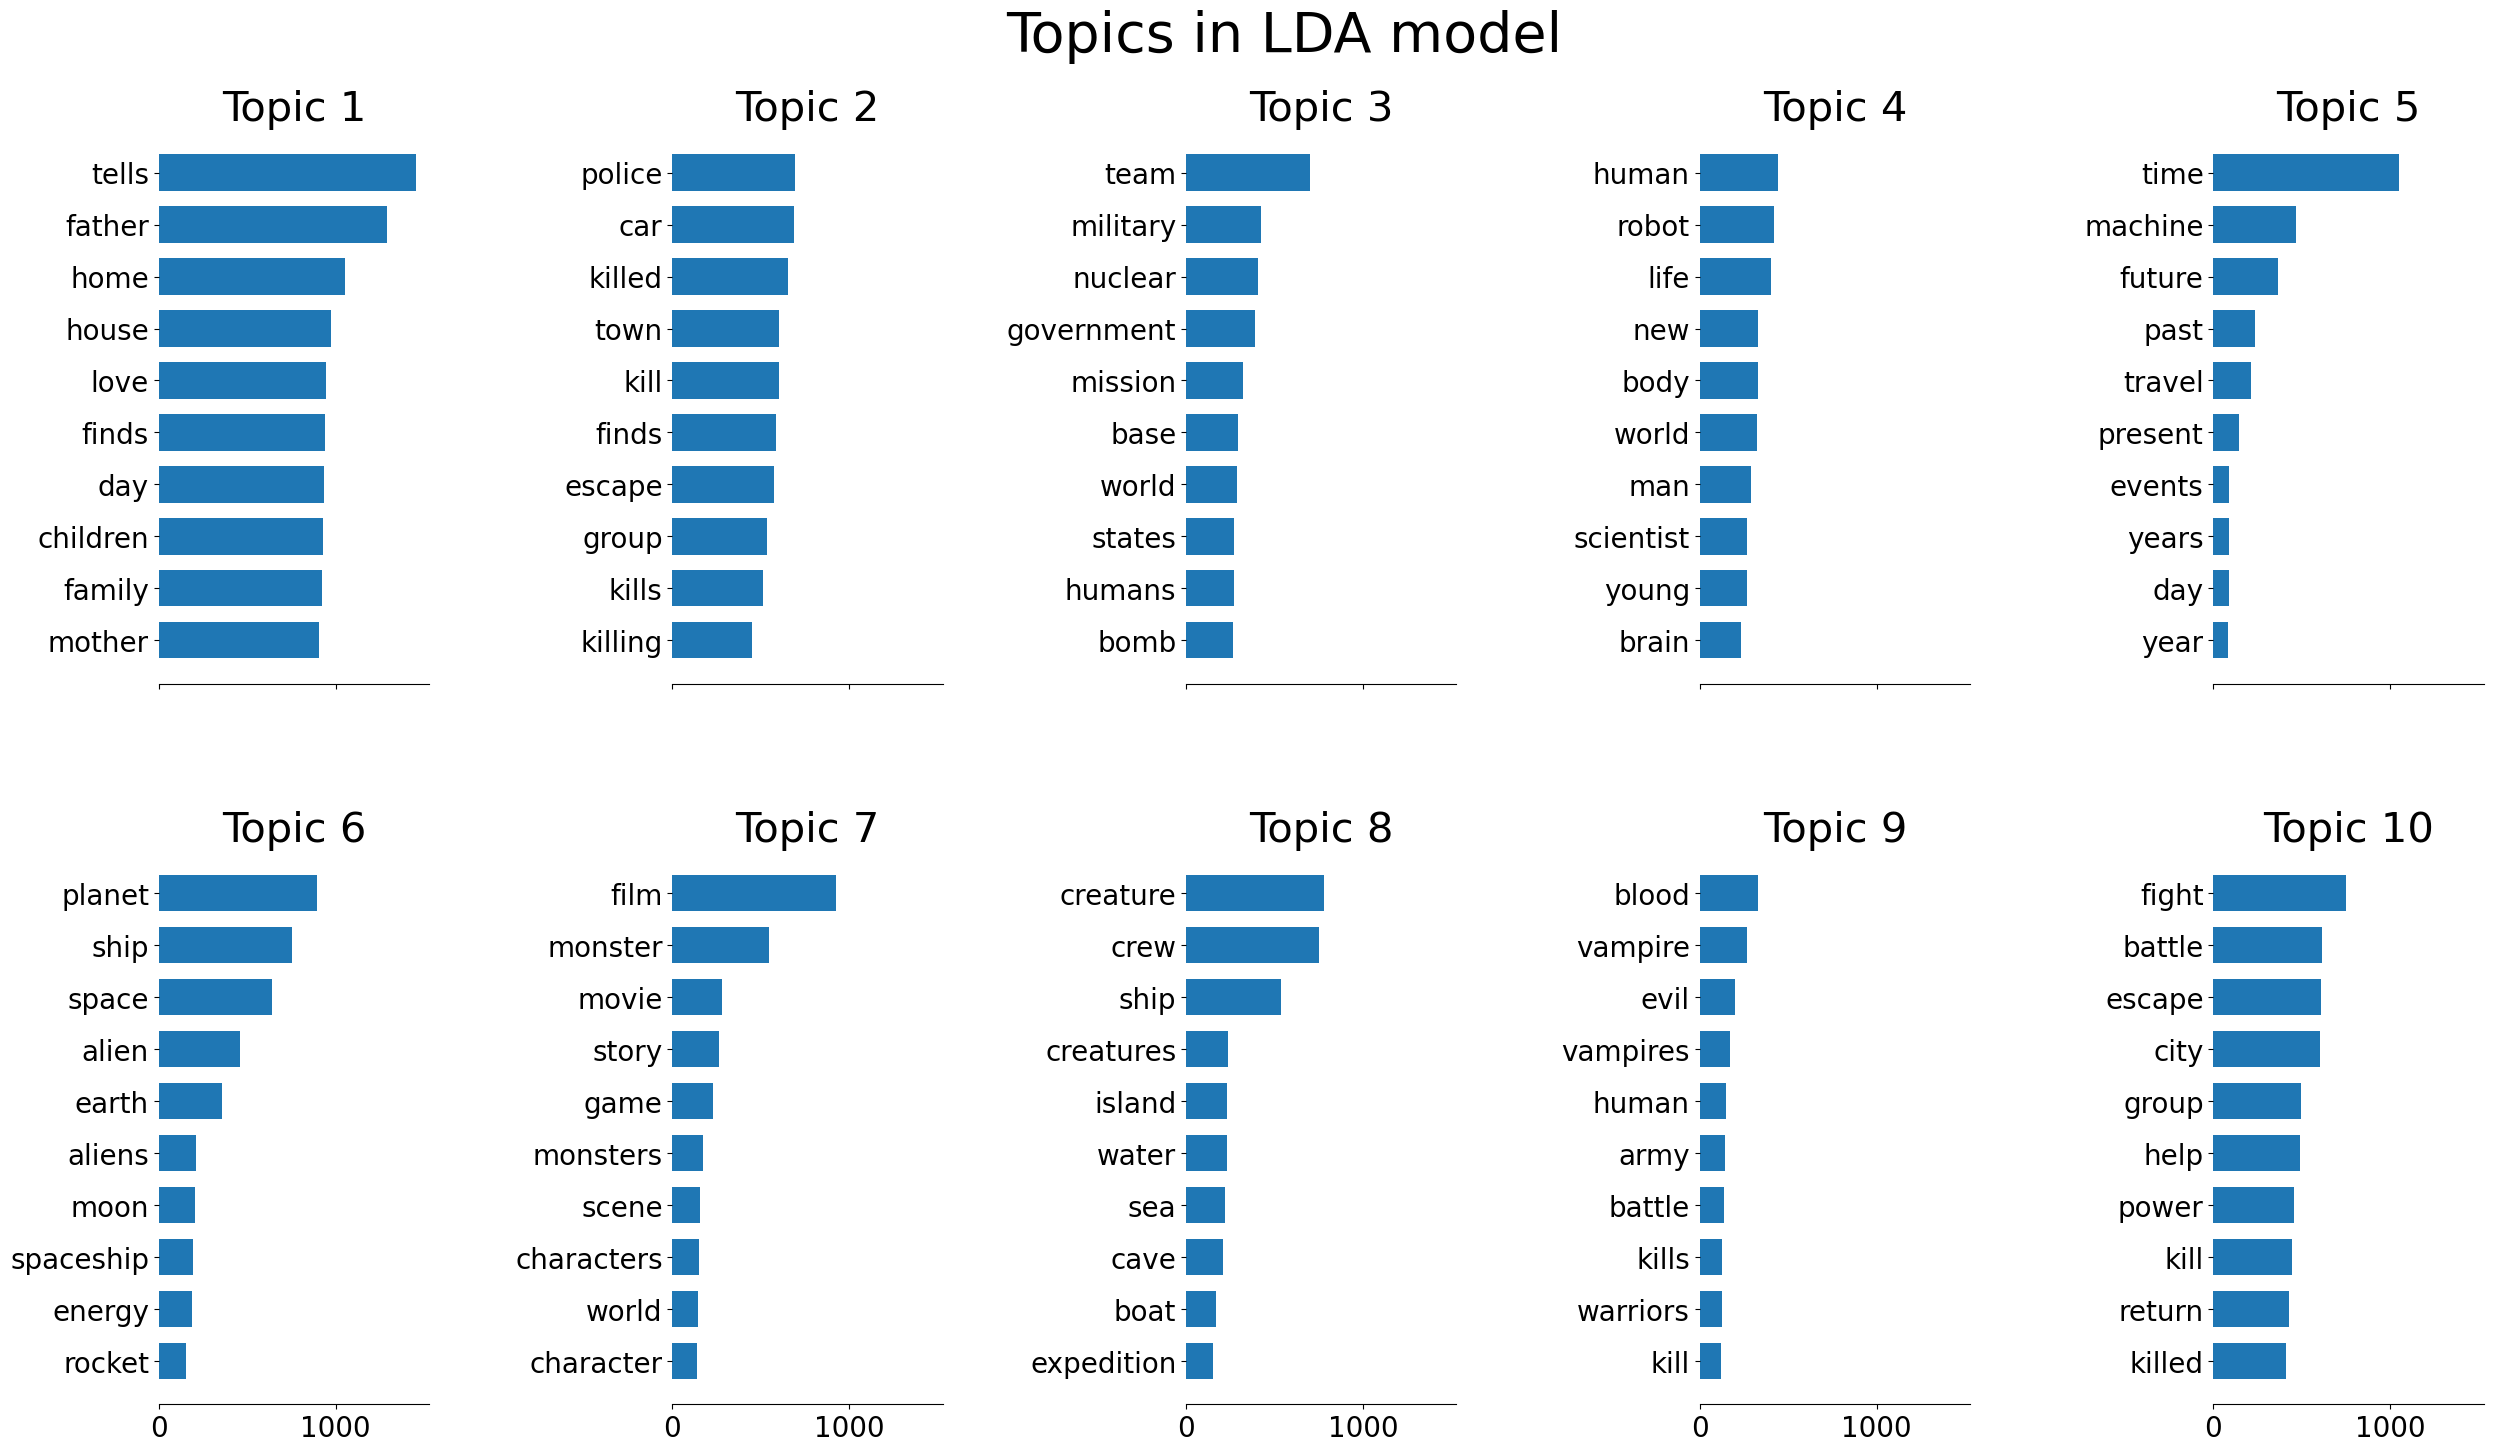

In [22]:
def plot_top_words(model, feature_names, n_top_words, n_topics, title):
    """_summary_

    Args:
        model (_type_): _description_
        feature_names (_type_): _description_
        n_top_words (_type_): _description_
        n_topics (_type_): _description_
        title (_type_): _description_
    """
    row_n = np.ceil(n_topics/5).astype(int)
    col_n = min([n_topics, 5])
    fig, axes = plt.subplots(row_n, col_n, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


tf_feature_names = vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, n_topics=n_components, title="Topics in LDA model")

In [23]:
def plot_difference_matplotlib(mdiff, title="", annotation=None):
    """Helper function to plot difference between models.

    Uses matplotlib as the backend."""
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(18, 14))
    data = ax.imshow(mdiff, cmap='RdBu_r', origin='lower')
    plt.title(title)
    plt.colorbar(data)

mdiff, annotation = lda.diff(lda, distance='jaccard', num_words=50)
plot_difference_matplotlib(mdiff, title="Topic difference (one model) [jaccard distance]", annotation=annotation)

AttributeError: 'LatentDirichletAllocation' object has no attribute 'diff'